# Setup data for experiments

## Imports

In [1]:
# Standard library imports
import time
import os

# 3rd party imports
import numpy as np
np.set_printoptions(linewidth=2000, threshold=10000)
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pprint import pprint
from scipy.ndimage import zoom
import SimpleITK as sitk

# Importing custom modules
from modules import laplacian
from modules import jacobian
from modules import correspondences

## Functions

In [ ]:
def plot_deformation(msample, fsample, deformation, title="", figsize=(20, 10), show_values=True, show_points=True, save_path=None):
    """
    Plots the deformation field between two sets of points.
    """
    
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    
    # Calculate the Jacobian determinant
    J = np.squeeze(jacobian.sitk_jacobian_determinant(deformation))
    num_neg_J = np.sum(J <= 0)
    norm = mcolors.TwoSlopeNorm(vmin=min(J.min(), J.min(), -3), vcenter=0, vmax=max(J.max(), J.max(), 3))

    # Draw lines connecting the points in the first subplot
    for i in range(len(msample)):  # Draw lines connecting the points
        axs[0].annotate(
            '', 
            xy=(fsample[i][2], fsample[i][1]), 
            xytext=(msample[i][2], msample[i][1]), 
            arrowprops=dict(facecolor='black', shrink=0.045, headwidth=8, headlength=10, width=3)
        )
    
    # Create a grid of points
    x, y = np.meshgrid(range(deformation.shape[3]), range(deformation.shape[2]), indexing='xy')

    # Plot the initial points and Jacobian determinant scores
    im = axs[0].imshow(J, cmap='seismic', norm=norm)
    axs[0].set_title(f"Jacobian determinant grid\n({num_neg_J} negative Jacobian values)")

    if show_values:
        # Add text for the values
        for i in range(J.shape[0]):
            for j in range(J.shape[1]):
                axs[0].text(j, i, f"{J[i, j]:.2f}", ha="center", va="center", color="black", fontsize=8)
        
        for i in range(J.shape[0]):
            for j in range(J.shape[1]):
                axs[1].text(j, i + 0.3, f"{J[i, j]:.2f}", ha="center", va="center", color="black", fontsize=8)

    # Plot the deformation vectors
    axs[1].set_title(f"Deformation vector field")
    axs[1].imshow(J, cmap='seismic', norm=norm)
    #pprint(deformation[2, 0])
    #print(np.max(deformation[2, 0]))
    #pprint(deformation[1, 0])
    #print(np.max(deformation[1, 0]))
    axs[1].quiver(x, y, deformation[2,0], deformation[1,0], scale=1, scale_units='xy', color='black')
    
    
    if show_points:
        axs[0].scatter(msample[:, 2], msample[:, 1], c='g', label='Moving')
        axs[0].scatter(fsample[:, 2], fsample[:, 1], c='violet', label='Fixed')
        axs[0].legend()
        axs[1].scatter(msample[:, 2], msample[:, 1], c='g', label='Moving')
        axs[1].scatter(fsample[:, 2], fsample[:, 1], c='violet', label='Fixed')
        axs[1].legend()
    
    # Draw very light grid lines between moving and fixed points
    for i in range(len(msample)):
        axs[1].plot(
            [msample[i][2], fsample[i][2]],
            [msample[i][1], fsample[i][1]],
            color='gray',
            linestyle='--',
            linewidth=1,
            alpha=0.5,
            zorder=1
        )
    
    # Invert y-axes
    axs[0].invert_yaxis()
    axs[1].invert_yaxis()
    
    # Set titles
    fig.suptitle(title, fontsize=16)
    
    # Add colorbar that matches the height of the axes
    divider = make_axes_locatable(axs[1])
    cax = divider.append_axes("right", size="5%", pad=0.15)
    cbar = fig.colorbar(im, cax=cax)
    cbar.set_label('Jacobian determinant')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path.replace('.npy', '.png'), bbox_inches='tight')
        
    plt.show()
    
    
def show_data(msample, fsample, fixed_sample, title="Deformation Field", figsize=(20, 10), show_values=True, show_points=True, save_path=None):
    """
    Displays the deformation field between two sets of points.
    """
    deformation, _, _, _, _ = laplacian.sliceToSlice3DLaplacian(fixed_sample, msample, fsample)
    np.save(save_path, deformation)
    print(title)
    print(f"Deformation field shape: {deformation.shape[2]} x {deformation.shape[3]}")
    print(f"Number of non-positive Jacobian values: {np.sum(jacobian.sitk_jacobian_determinant(deformation) <= 0)}")
    plot_deformation(msample, fsample, deformation, title=title, figsize=figsize, show_values=show_values, show_points=show_points, save_path=save_path)

In [5]:
def generate_random_dvf(shape, max_magnitude=5.0, seed=None):
    """
    Generate a random 2D deformation vector field (DVF).
    
    Parameters:
        shape: tuple (3, 1, H, W)
        max_magnitude: float, max displacement in pixels
        seed: int or None, for reproducibility

    Returns:
        np.ndarray of shape (3, 1, H, W)
    """
    if seed is not None:
        np.random.seed(seed)

    C, _, H, W = shape
    assert C == 3, "DVF must have 3 channels (dz, dy, dx)"
    
    # Uniform random displacement in range [-max_magnitude, +max_magnitude]
    dvf = np.random.uniform(-max_magnitude, max_magnitude, size=shape).astype(np.float32)
    return dvf


def scale_dvf_numpy(dvf, new_size):
    """
    Downscale a deformation vector field (DVF).
    dvf: np.ndarray of shape (3, 1, H, W)
    new_size: (new_H, new_W)
    """
    C, _, H, W = dvf.shape
    new_H, new_W = new_size
    scale_y = new_H / H
    scale_x = new_W / W

    dvf_resized = np.zeros((C, 1, new_H, new_W), dtype=dvf.dtype)
    for c in range(C):
        # zoom along spatial dimensions
        dvf_resized[c, 0] = zoom(dvf[c, 0], (scale_y, scale_x), order=1)

    # scale vector magnitudes appropriately
    dvf_resized[2, 0] *= scale_x  # x
    dvf_resized[1, 0] *= scale_y  # y
    #dvf_resized[2, 0] *= (scale_x + scale_y) / 2  # z, if needed

    return dvf_resized

## Data setup

Sample 1 - 10x10 crossing points
Deformation field shape: 10 x 10
Number of non-positive Jacobian values: 9
array([[ 1.80879656,  1.67661869,  1.35644063,  0.78687371,  0.07721966, -0.63217341, -1.20279794, -1.52645362, -1.67416033, -1.72885903],
       [ 1.9377022 ,  1.8608261 ,  1.60026144,  0.91954073,  0.07083339, -0.77744437, -1.45860052, -1.70618271, -1.77145574, -1.78356338],
       [ 2.1403748 ,  2.22634135,  2.26049409,  1.21211251,  0.06039529, -1.09804528, -2.1561457 , -2.07255989, -1.92616006, -1.85246968],
       [ 2.255824  ,  2.642202  ,  3.99968029,  1.6047583 ,  0.04991799, -1.52234458, -3.99968029, -2.50497017, -2.01229039, -1.85063974],
       [ 1.98322419,  2.08591976,  2.15324168,  1.15316107,  0.05757472, -1.04478635, -2.05630559, -1.93944951, -1.77286751, -1.69061322],
       [ 1.60659157,  1.56249299,  1.37048247,  0.79257365,  0.06756439, -0.66061836, -1.24283529, -1.4241535 , -1.45352958, -1.44998629],
       [ 1.27051373,  1.18443947,  0.96852287,  0.57202767

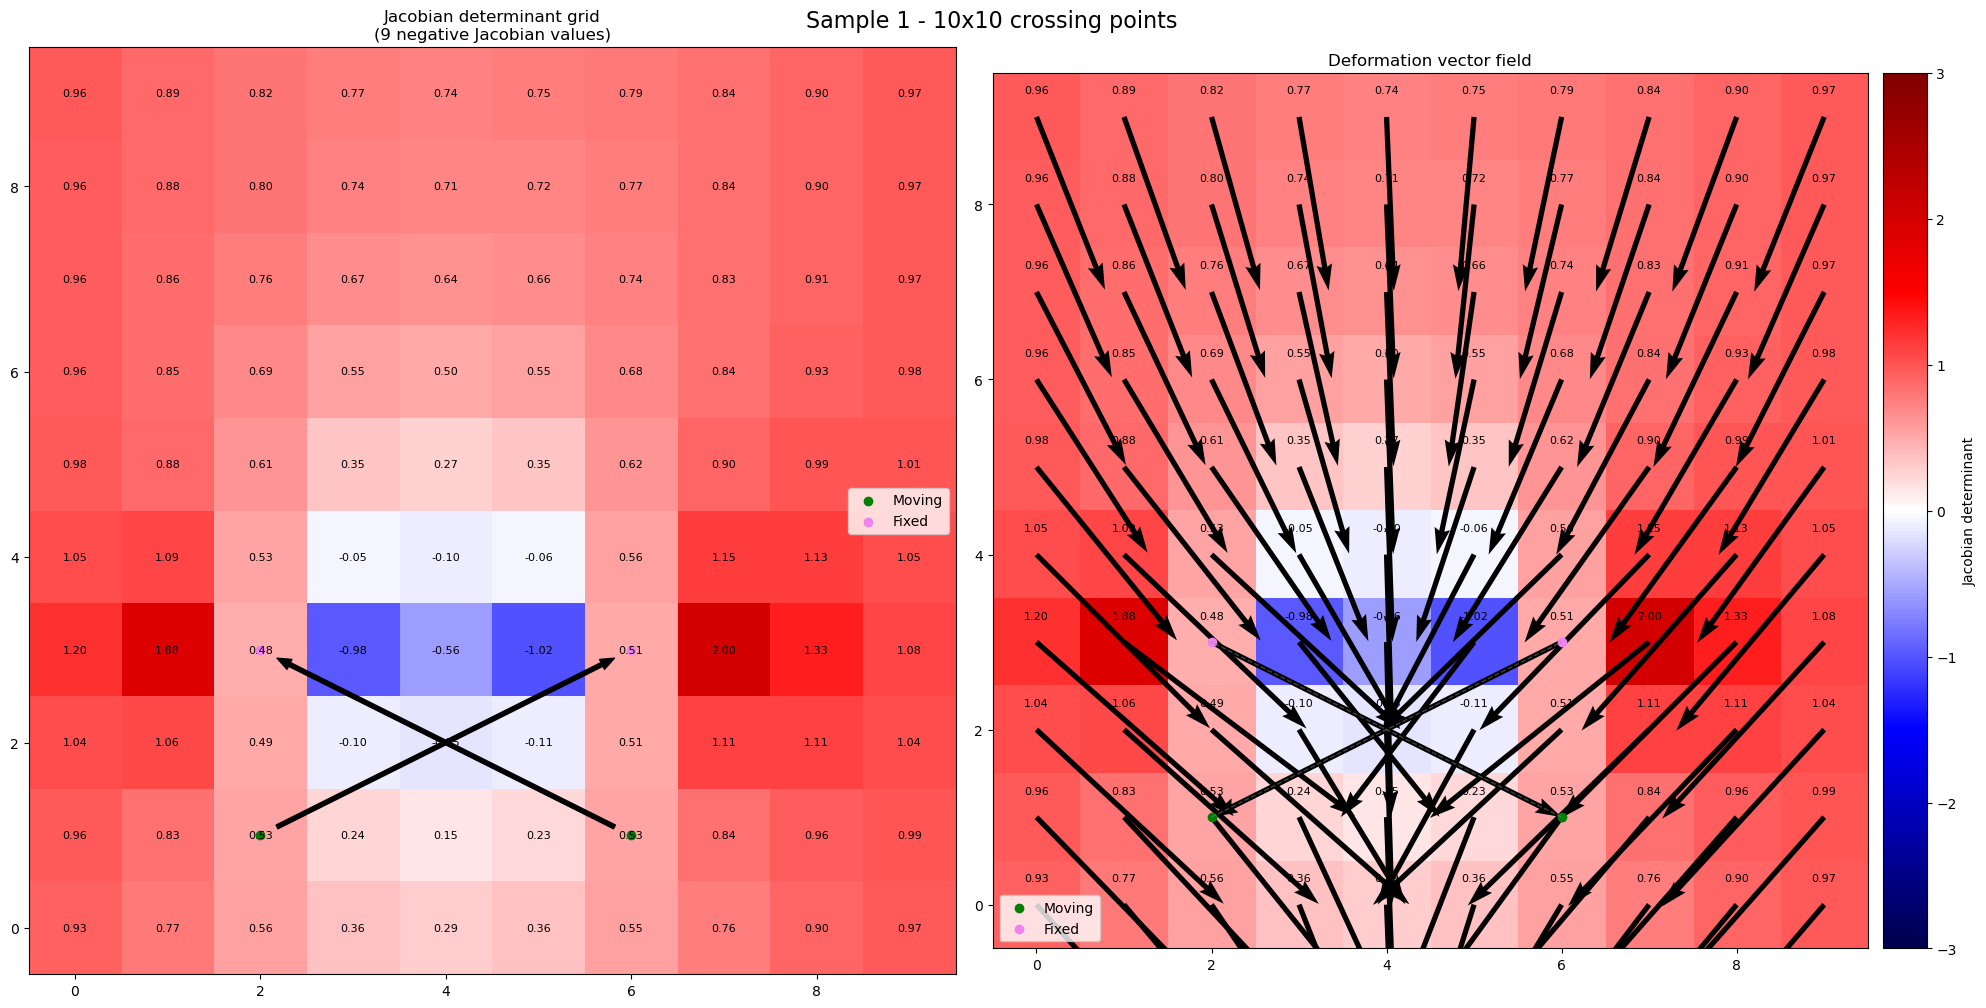

In [3]:
# Data title and where to save the output and results
title = "Sample 1 - 10x10 crossing points"
save_path = "experiments/01_10x10_crossing.npy"

# Sample moving and fixed points
msample = np.array([
    [0, 1, 2],
    [0, 1, 6],
])
fsample = np.array([
    [0, 3, 6],
    [0, 3, 2],
])
resolution = (10, 10)  # y, x (height x width)

##############################################################################################################

# Show and save the experiment data
show_data(msample, fsample, np.zeros((1, resolution[0], resolution[1])), title=title, figsize=(20, 10), show_values=True, show_points=True,
          save_path=save_path)

Sample 2 - Slice 350 Downscaled 20% (64 x 91)
Deformation field shape: 80 x 114
Number of non-positive Jacobian values: 0
array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  7.04855530e-17,  9.41713284e-08,  8.83009691e-06,  3.14585925e-04,  2.97428191e-03,  1.07699416e-02,  2.13611033e-02,  2.91513207e-02,  3.03814299e-02,  2.22511352e-02,  5.01853470e-03, -1.92204126e-02, -4.44701994e-02, -6.31461010e-02, -6.71991738e-02, -5.42783698e-02, -2.71795461e-02,  7.96229951e-03,  4.34302320e-02,  7.46070810e-02,  1.03723992e-01,  1.37823855e-01,  1.81524871e-01,  2.46150679e-01,  3.42622023e-01,  4.37658859e-01,  4.56734592e-01,  3.75351251e-01,  2.48962513e-01,  1.33119839e-01,  3.55167478e-02, -6.06870842e-02, -1.

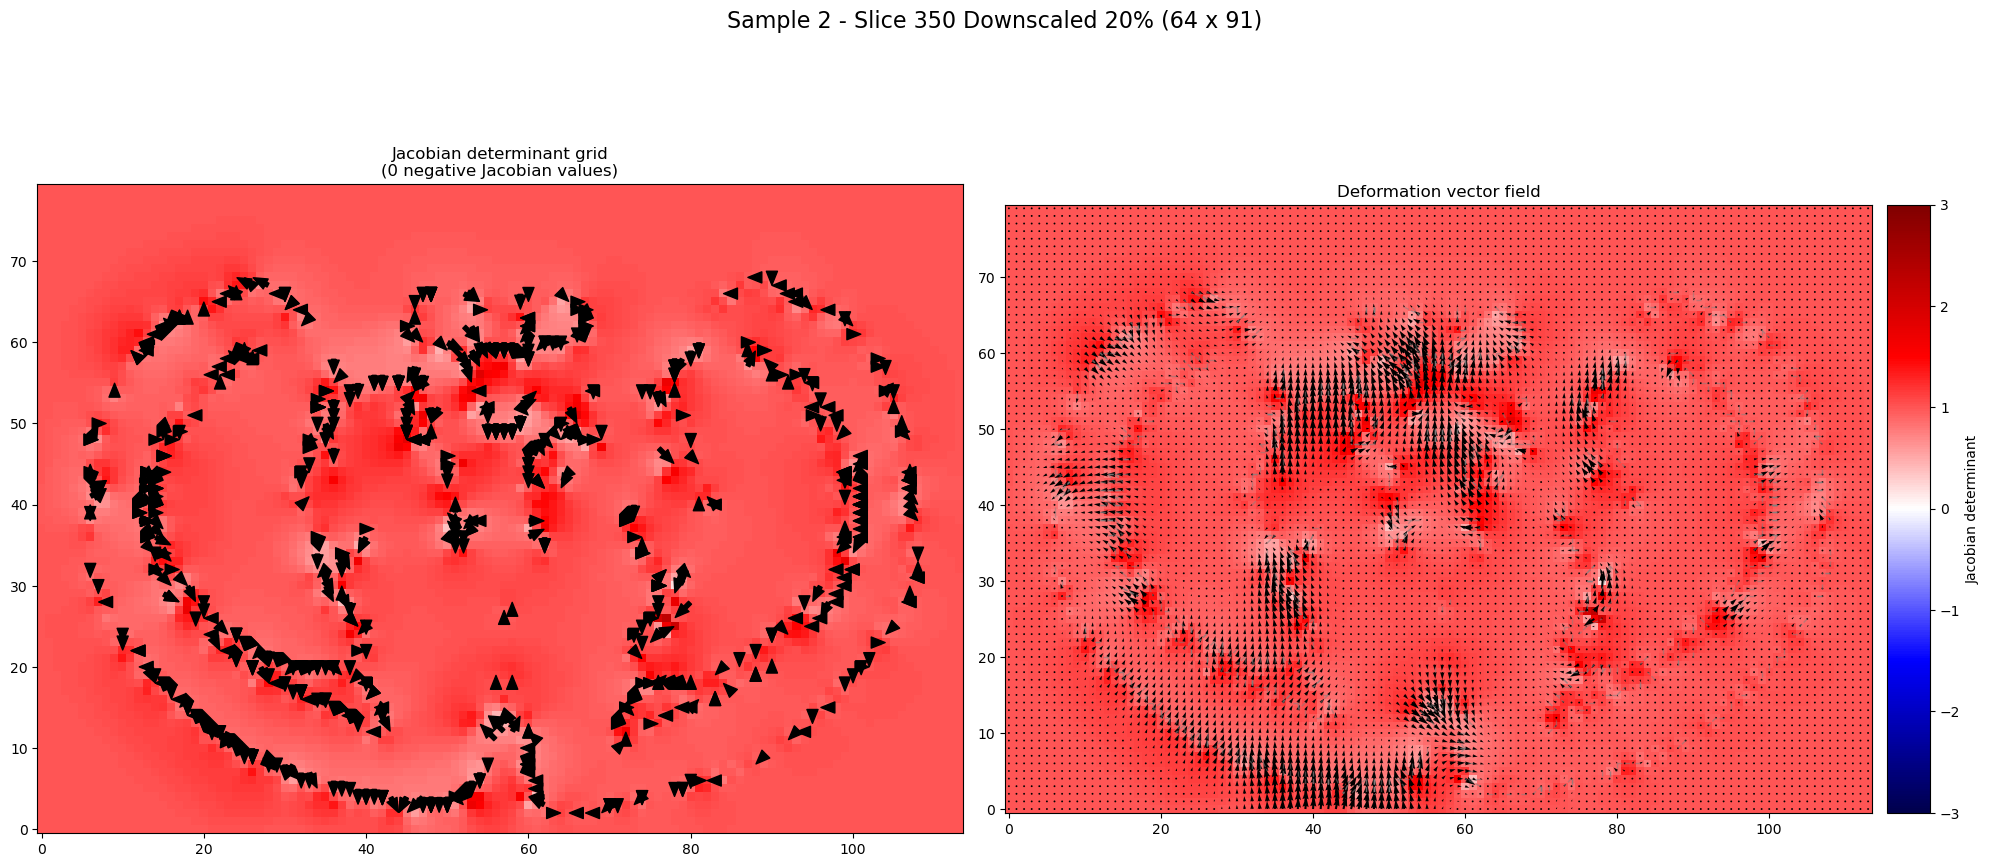

Max vector magnitude in the deformation field: 2.394399884991173


In [6]:
def load_slice(idx, mpoints_path="data/corrected_correspondences_count_touching/mpoints.npy", fpoints_path="data/corrected_correspondences_count_touching/fpoints.npy", 
               scale_factor=1.0, show_values=False, show_points=False, title="",
               save_path=None):
    """
    Load a specific slice of moving and fixed points from the given paths.
    """
    msample = np.load(mpoints_path)
    fsample = np.load(fpoints_path)
    
    fixed_sample = np.zeros((1, 320, 456))  # Adjusted size for smaller resolution

    # Filter points for the specified slice
    mask_m = msample[:, 0] == idx
    mask_f = fsample[:, 0] == idx

    new_mpoints = msample[mask_m].copy()
    new_fpoints = fsample[mask_f].copy()

    new_mpoints[:, 0] = 0
    new_fpoints[:, 0] = 0
    
    # Create a deformation field with Laplacian
    deformation, _, _, _, _ = laplacian.sliceToSlice3DLaplacian(fixed_sample, new_mpoints, new_fpoints)
    
    # Upscale or downscale the deformation field based on the scale factor
    if scale_factor != 1.0:
        new_mpoints[:, :] = np.round(new_mpoints[:, :] * scale_factor).astype(int)
        new_fpoints[:, :] = np.round(new_fpoints[:, :] * scale_factor).astype(int)
        deformation = scale_dvf_numpy(deformation, (int(320 * scale_factor), int(456 * scale_factor)))
    if save_path:
        np.save(save_path, deformation)
        
    print(title)
    print(f"Deformation field shape: {deformation.shape[2]} x {deformation.shape[3]}")
    print(f"Number of non-positive Jacobian values: {np.sum(jacobian.sitk_jacobian_determinant(deformation) <= 0)}")
    plot_deformation(new_mpoints, new_fpoints, deformation, title=title, figsize=(20, 10), show_values=show_values, show_points=show_points, save_path=save_path)
    return deformation
    
deform = load_slice(350, scale_factor=0.25, show_values=False, show_points=False, title="Sample 2 - Slice 350 Downscaled 20% (64 x 91)", save_path="experiments/02_64x91_slice350.npy")
#plot_deformation(np.array([[0, 0, 0]]), np.array([[0, 0, 0]]), deform, title=title, figsize=(20, 10), show_values=False, show_points=False, save_path=None)

# Compute the max vector magnitude in the deformation field
magnitudes = np.linalg.norm(deform, axis=0)  # shape: (1, H, W)
magnitudes = np.squeeze(magnitudes)           # shape: (H, W)
max_magnitude = np.max(magnitudes)
print(f"Max vector magnitude in the deformation field: {max_magnitude}")

In [ ]:
deform.shape

(3, 1, 16, 22)